# Actor-Actor Superimposition

Combining actor-actor interactions using bitwise operations on actor-actor matrices from different spaces.

Can actor-actor matrices be created that act as filters, e.g. party/third party?


## TODO

- Use PA-X actor IDs as keys and the <prefix>_<pax_id> form as label
- Time series analysis. Currently aggregating over date.
- Handle the subsumed dimension in actor-actor matrices derived from biadjacency matrices.
- Party/third party analysis in the agreement space.
- Expand mediation processing to include more metadata and edge properties.




In [167]:
__author__      = 'Roy Gardner'

%run ./network_functions.py


## Load the data

Loading:
- Agreement-actor signatory data including the agreement-actor biadjacency matrix.
- Mediation event-actor data including the event-actor biadjacency matrix.


In [168]:
data_path = '../paax_data/v8/'

# Actor data in this file
actors_file = 'paax_actor_table.csv'

# Links agreements to actors and define status as party/third-party
signatories_file = 'paax_signatories_v8.csv'

# PAX agreements database dump
agreements_file = 'pax.csv'

# Relationship of agreement to country
countries_file = 'pax_v8_id_to_con_info.csv'

data_dict = load_agreement_actor_data(actors_file,signatories_file,agreements_file,countries_file,data_path)

# Map PA-X actor IDs onto agreement actor IDs
pax_actor_dict = {v['id']:k for k,v in data_dict['actors_dict'].items()}


# Load mediation data
mediation_path = '../mediation/data/'

mediating_actors_file = 'mediating_actors.csv'
events_actors_file = 'events_actors.csv'
events_file = 'events.csv'
locations_file = 'locations.csv'

mediation_data_dict = load_mediation_data(mediating_actors_file,events_actors_file,events_file,\
                                          locations_file,pax_actor_dict,mediation_path)

# Load UCDP data
ucdp_path = '../paax_data/'
ucdp_data_file = 'GEDEvent_v24_1.csv'

with open(ucdp_path + ucdp_data_file, encoding='utf-8', errors='replace') as f:
    reader = csv.reader(f)
    ucdp_header = next(reader)
    ucdp_data = [row for row in reader]
    f.close()
    
# Build a map to translate UCDP identifiers into PA-X identifiers
ucdp_pax_map = {}
for actor_id in data_dict['actor_ids']: 
    ucdp_id = data_dict['actors_dict'][actor_id]['ucdp_id']
    if ucdp_id == -1:
        continue
    ucdp_pax_map[ucdp_id] = actor_id


# Sudan

Peace process: **Sudan Transition Process**

Analysis is restricted to mediation event actors that have PA-X identities.

There are two spaces.

In agreement space:
- An actor is a set of agreements
- An agreement is a set of actors
- The intersection of the agreement sets of a set of actors provides the number of agreements the actors have in common

In mediation space:
- An actor is a set of mediation events
- A mediation event is a set of actors
- The intersection of the mediation event sets of a set of actors provides the number of mediation events the actors have in common



## Agreement space

Actor-actor matrix in agreement space for the Sudan Transition Process.


['ARM_1113', 'ARM_1114', 'ARM_155', 'ARM_156', 'ARM_283', 'ARM_943', 'ARM_944', 'ARM_945', 'ARM_946', 'ARM_947', 'ARM_948', 'ARM_949', 'ARM_951', 'ARM_958', 'ARM_959', 'COA_918', 'CON_158', 'CON_159', 'CON_173', 'CON_19', 'CON_3', 'CON_419', 'CON_486', 'CON_81', 'CON_82', 'IGO_312', 'IGO_346', 'IGO_49', 'IGO_5', 'IGO_673', 'IGO_87', 'IGO_950', 'OTH_1018', 'OTH_933', 'OTH_934', 'OTH_968', 'POL_868']


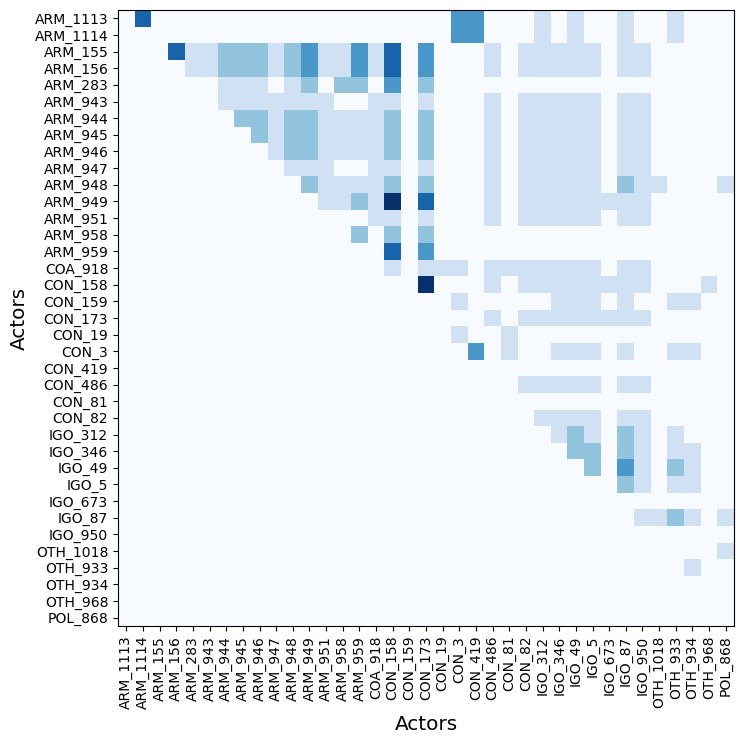

In [182]:
process_name = 'Sudan Transition Process'

pp_data_dict = get_peace_process_data(process_name,data_dict)
pp_matrix = pp_data_dict['matrix']

actor_upper = np.triu(get_cooccurrence_matrices(pp_matrix)[0],k=1)

f = plt.figure(figsize=(8,8))
plt.imshow(actor_upper,cmap=plt.cm.Blues)
plt.xticks(range(0,len(pp_data_dict['actor_ids'])),pp_data_dict['actor_ids'],rotation=90)
plt.yticks(range(0,len(pp_data_dict['actor_ids'])),pp_data_dict['actor_ids'])
plt.xlabel('Actors',fontsize='x-large')
plt.ylabel('Actors',fontsize='x-large')
plt.show()



## Mediation Event Space

Actor-actor matrix in the mediation event space.


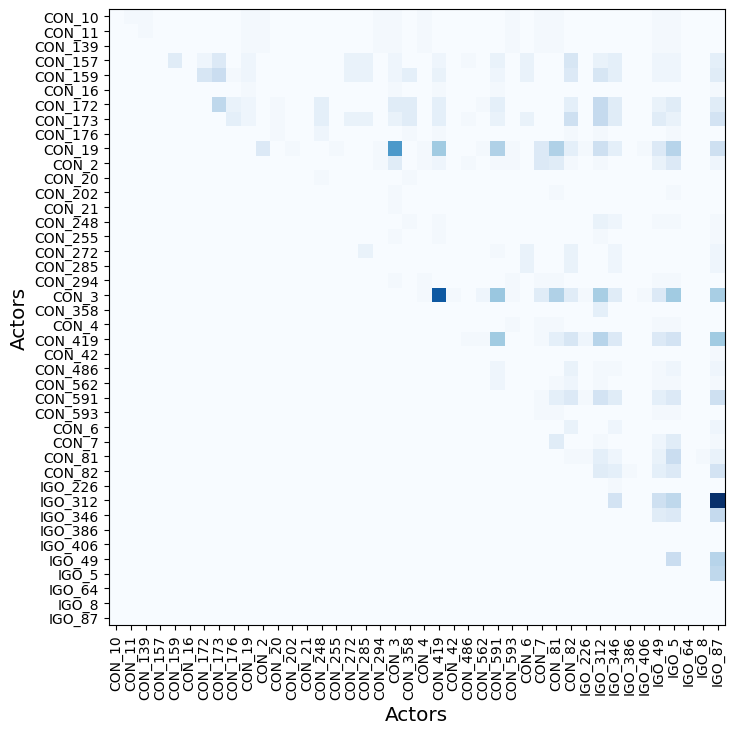

In [183]:
# Get actor-actor matrix for mediation events

med_matrix = mediation_data_dict['matrix']

med_actor_upper = np.triu(np.matmul(med_matrix.T,med_matrix),k=1)

f = plt.figure(figsize=(8,8))
plt.imshow(med_actor_upper,cmap=plt.cm.Blues)
plt.xticks(range(0,len(mediation_data_dict['actor_ids'])),mediation_data_dict['actor_ids'],rotation=90)
plt.yticks(range(0,len(mediation_data_dict['actor_ids'])),mediation_data_dict['actor_ids'])
plt.xlabel('Actors',fontsize='x-large')
plt.ylabel('Actors',fontsize='x-large')
plt.show()


## UCDP Conflict Space

1691
['ARM_958', 'CON_158', 'ARM_283', 'ARM_155', 'ARM_156', 'ARM_959']


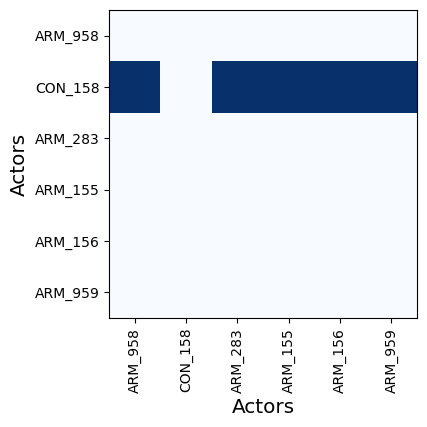

In [207]:
ucdp_con_id = pp_data_dict['ucdp_con_id']

sudan_rows = []
for row in ucdp_data:
    if int(row[ucdp_header.index('conflict_new_id')].strip()) == ucdp_con_id:
        sudan_rows.append(row)
        
print(len(sudan_rows))

# Get the actor sets
conflict_actors = []
for row in sudan_rows:
    conflict_actors.append(int(row[ucdp_header.index('side_a_new_id')].strip()))
    conflict_actors.append(int(row[ucdp_header.index('side_b_new_id')].strip()))  
conflict_actors = list(set(conflict_actors))

actor_ids = []
for ucdp_id in conflict_actors:
    if ucdp_id in ucdp_pax_map:
        actor_id = ucdp_pax_map[ucdp_id]
        if actor_id in pp_data_dict['actor_ids']:
            actor_ids.append(ucdp_pax_map[ucdp_id])
#actor_ids = sorted(actor_ids)
print(actor_ids)

# Hard wired for now
conflict_map = {}
conflict_map['CON_158'] = []
conflict_map['CON_158'].append('ARM_155')
conflict_map['CON_158'].append('ARM_156')
conflict_map['CON_158'].append('ARM_283')
conflict_map['CON_158'].append('ARM_958')
conflict_map['CON_158'].append('ARM_959')

matrix = np.zeros((len(actor_ids),len(actor_ids)))
for side_a,side_b in conflict_map.items():
    side_a_index = actor_ids.index(side_a)
    for b in side_b:
        side_b_index = actor_ids.index(b)
        matrix[side_a_index,side_b_index] = 1

f = plt.figure(figsize=(4,4))
plt.imshow(matrix,cmap=plt.cm.Blues)
plt.xticks(range(0,len(actor_ids)),actor_ids,rotation=90)
plt.yticks(range(0,len(actor_ids)),actor_ids)
plt.xlabel('Actors',fontsize='x-large')
plt.ylabel('Actors',fontsize='x-large')
plt.show()

conflict_data_dict = {}
conflict_data_dict['matrix'] = matrix
conflict_data_dict['actor_ids'] = actor_ids


## Superimposition: agreement-conflict

### Overlap of sets of actors


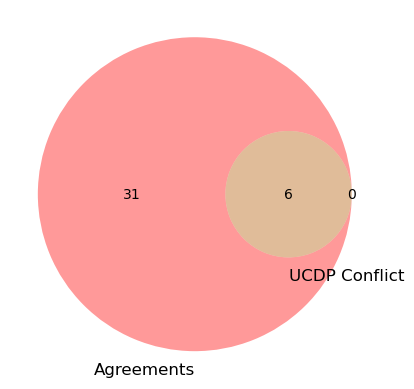

In [210]:
venn2([set(pp_data_dict['actor_ids']),set(conflict_data_dict['actor_ids'])],\
     ['Agreements','UCDP Conflict'])
plt.show()


### Compute and visualise superimposition

- Combine actors from agreements and conflict into a superset
- Build super matrices with superset actors in rows and columns:
    - One super matrix contains actor-actor interactions in the agreement space.
    - The other super matrix contains actor-actor interactions in the conflict space.
    - Bitwise AND the matrices to provide a matrix containing actor-actor pairs with interactions in both the agreement and conflict spaces.
- Plot network with one super matrix as the base space and superimpose the bitwise matrix with coloured edges to indicate an interaction between a pair of actors in the other space.
    


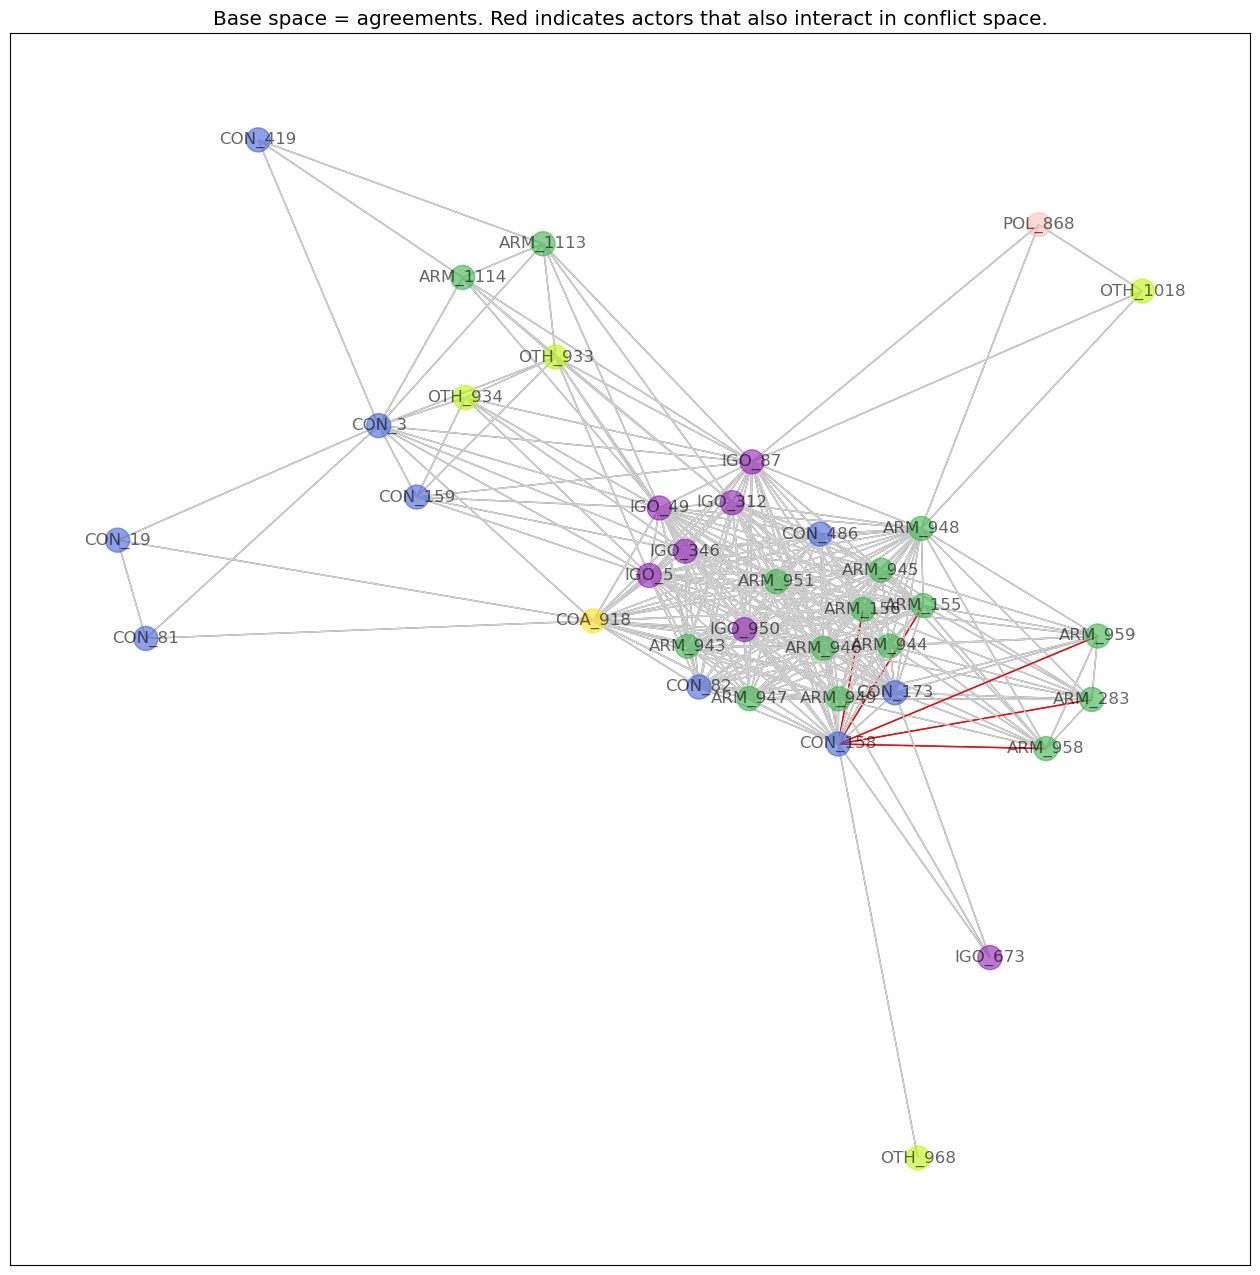

In [211]:
super_set = sorted(list(set(pp_data_dict['actor_ids']).union(set(conflict_data_dict['actor_ids']))))

matrix1 = np.zeros((len(super_set),len(super_set))).astype(np.int_)

indices_map1 = {i:super_set.index(name) for i,name in enumerate(pp_data_dict['actor_ids'])}
indices1 = list(np.where(actor_upper>0))
z = list(zip(indices1[0],indices1[1]))
z = [(indices_map1[t[0]],indices_map1[t[1]]) for t in z]
    
for t in z:
    matrix1[t[0],t[1]] = 1
    

matrix2 = np.zeros((len(super_set),len(super_set))).astype(np.int_)

indices_map2 = {i:super_set.index(name) for i,name in enumerate(conflict_data_dict['actor_ids'])}
indices2 = list(np.where(conflict_data_dict['matrix']>0))
z = list(zip(indices2[0],indices2[1]))
z2 = [(indices_map2[t[0]],indices_map2[t[1]]) for t in z]
z2.extend([(indices_map2[t[1]],indices_map2[t[0]]) for t in z])

for t in z2:
    matrix2[t[0],t[1]] = 1

c = np.bitwise_and(matrix1,matrix2)

if not np.any(c):
    print('No superimposition')
    
title = 'Base space = agreements. Red indicates actors that also interact in conflict space.'
visualise_superimposition(matrix1,c,super_set,data_dict,'red',title)



## Superimposition: agreement-mediation

### Overlap of sets of actors

Interactions in both spaces are only possible for actors in the intersection of the agreement and mediation event actor sets.


37


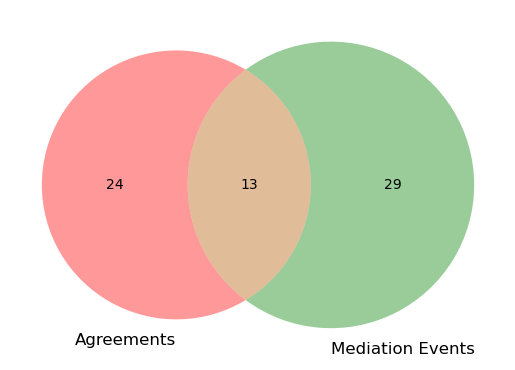

Actors in the intersection:

IGO_87 African Union
IGO_346 League of Arab States
CON_3 United States
CON_486 Qatar
CON_19 United Kingdom
CON_82 Egypt
IGO_5 European Union
CON_419 Saudi Arabia
CON_81 Norway
CON_159 Ethiopia
CON_173 South Sudan
IGO_49 United Nations (General)
IGO_312 Intergovernmental Authority on Development



In [176]:
print(len(pp_data_dict['actor_ids']))

venn2([set(pp_data_dict['actor_ids']),set(mediation_data_dict['actor_ids'])],\
      ['Agreements','Mediation Events'])       
plt.show()

print('Actors in the intersection:')
print()
intersection = set(pp_data_dict['actor_ids']).intersection(set(mediation_data_dict['actor_ids']))       
for actor_id in intersection:
    print(actor_id,get_actor_name(actor_id,data_dict))
print()


### Compute and visualise superimposition

- Combine actors from agreements and mediation events into a superset
- Build super matrices with superset actors in rows and columns:
    - One super matrix contains actor-actor interactions in the agreement space.
    - The other super matrix contains actor-actor interactions in the mediation event space.
    - Bitwise AND the matrices to provide a matrix containing actor-actor pairs with interactions in both the agreement and mediation event spaces.
- Plot network with one super matrix as the base space and superimpose the bitwise matrix with coloured edges to indicate an interaction between a pair of actors in the other space.
    


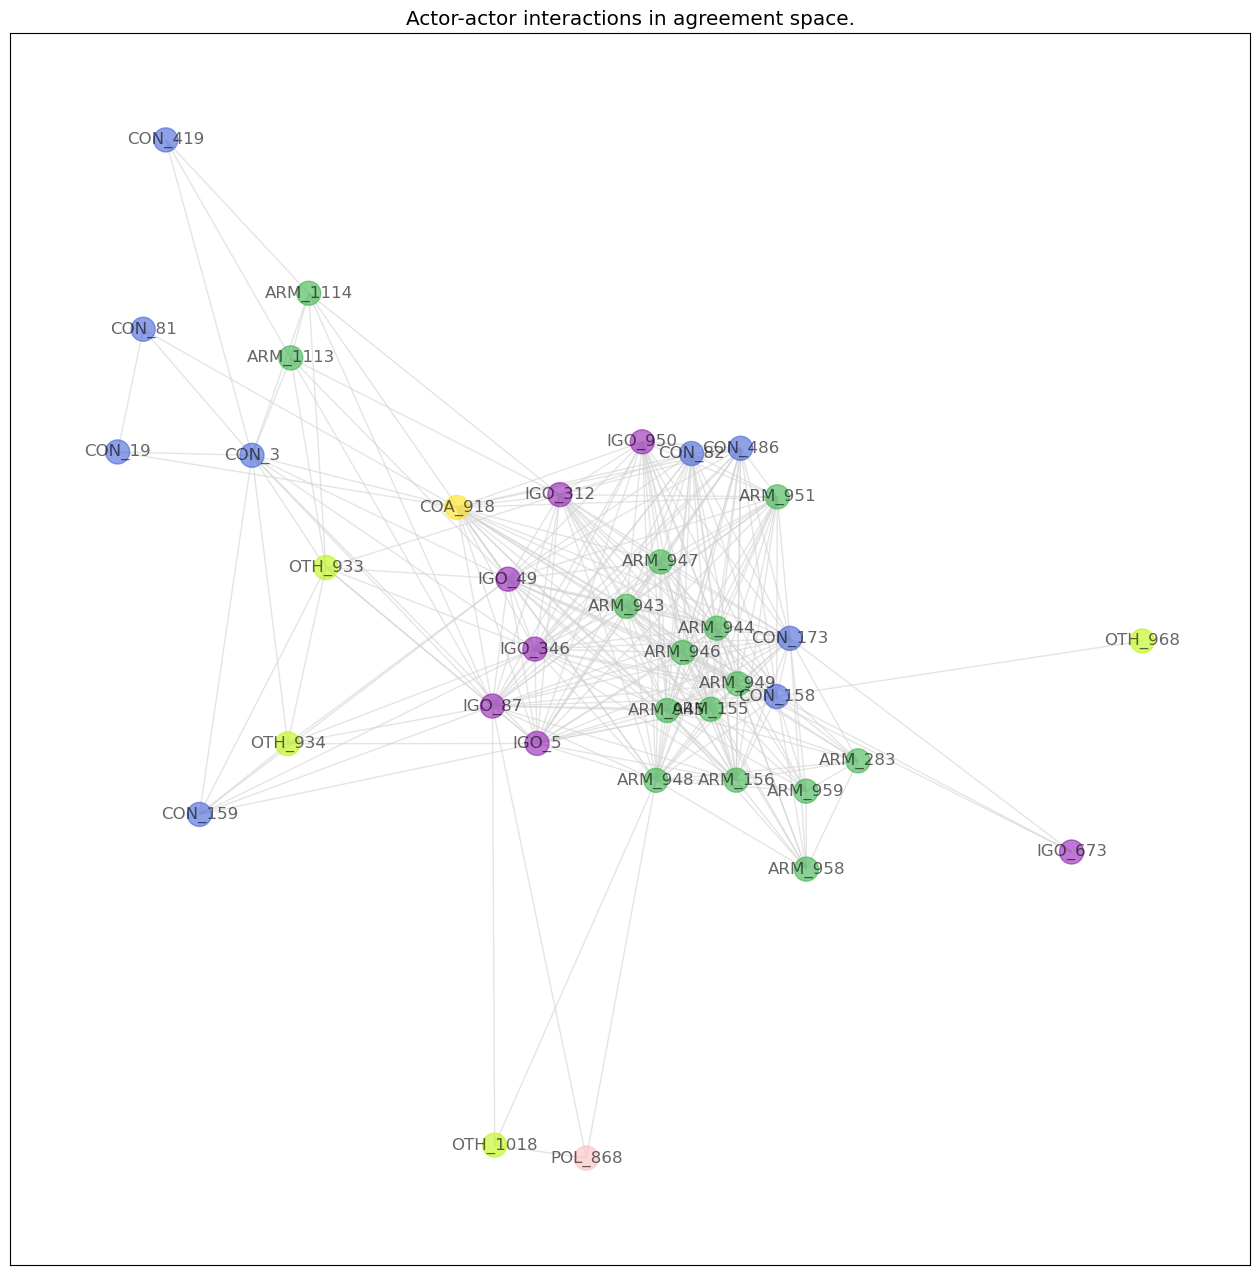

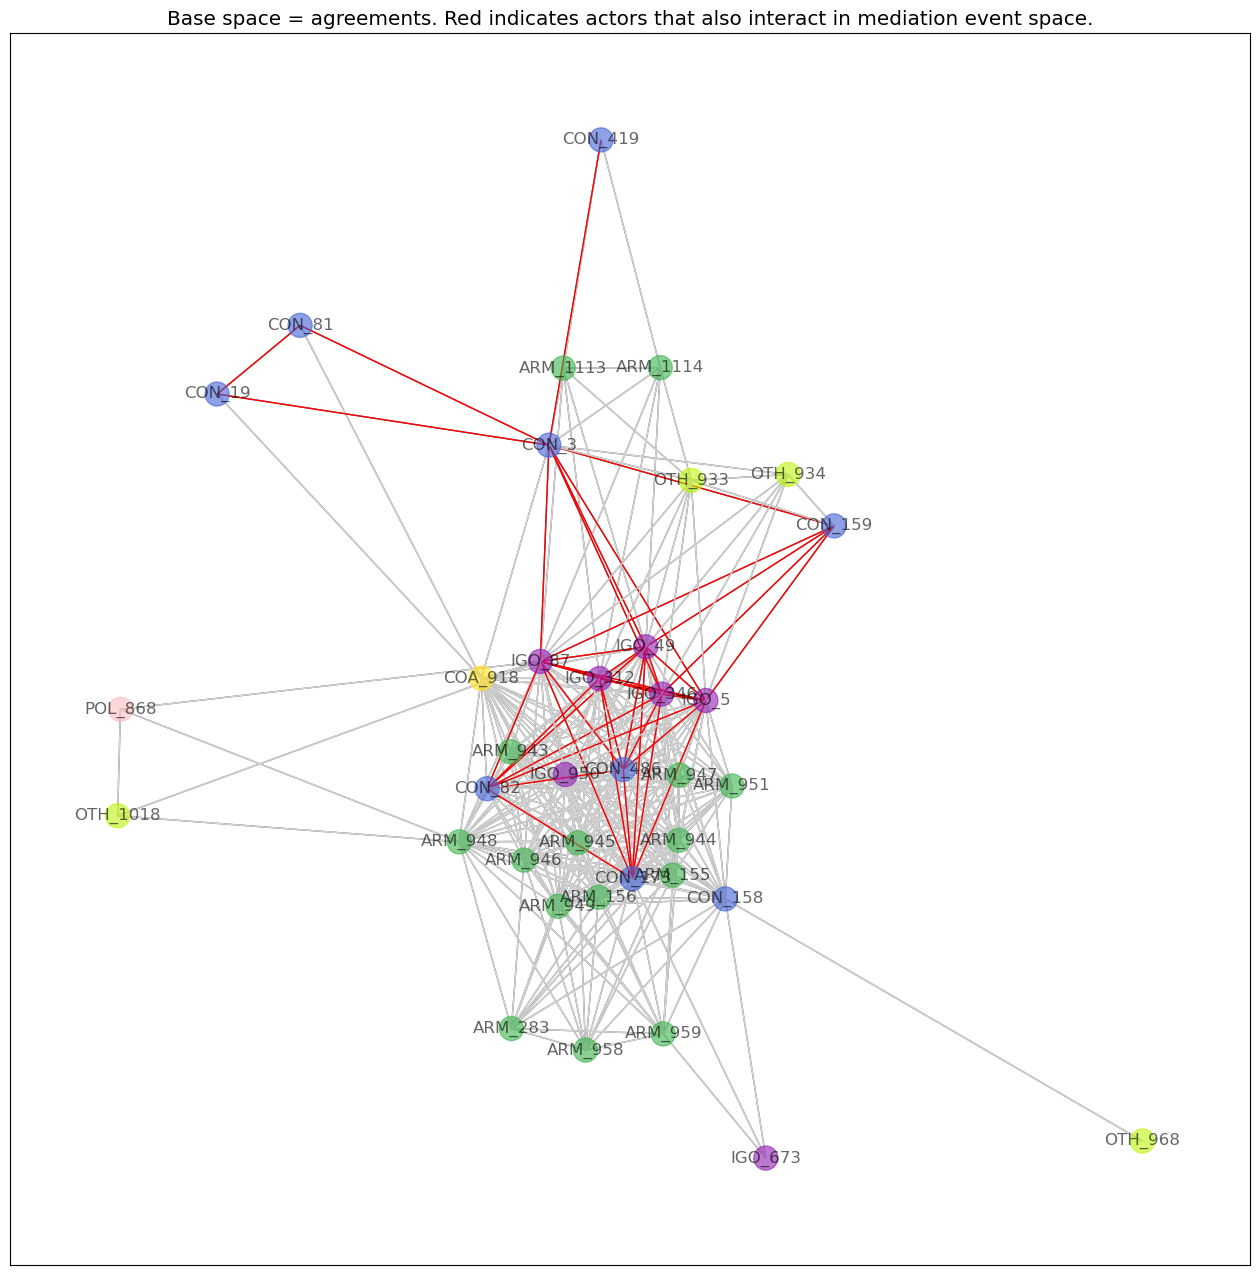

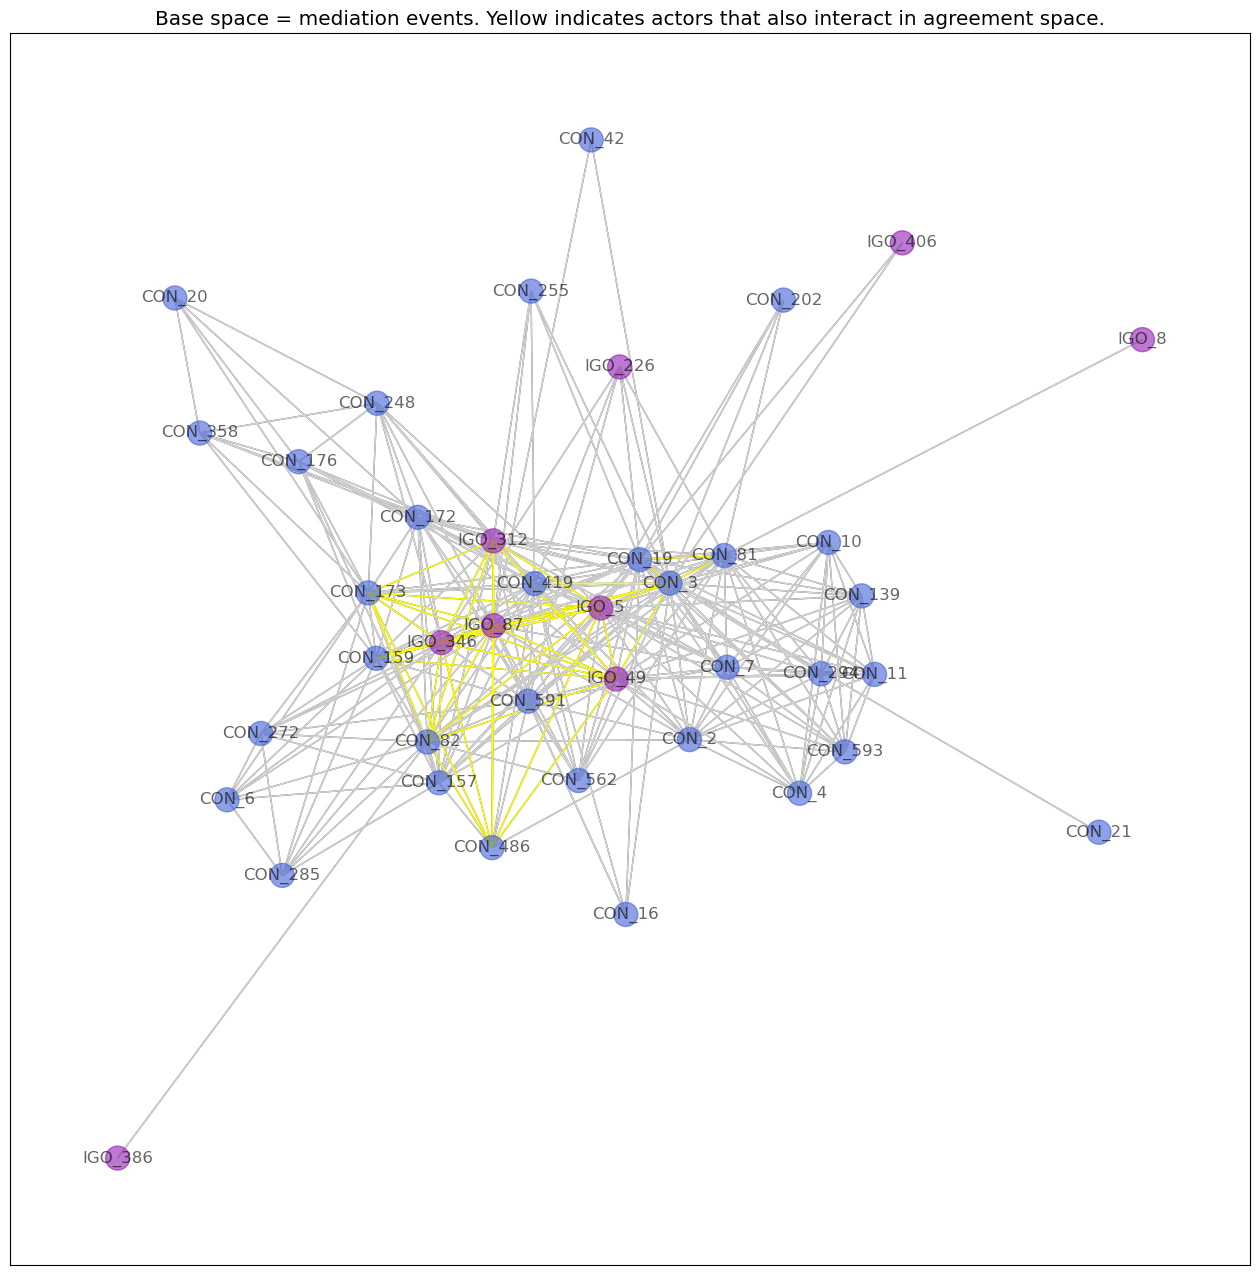

In [177]:
f = plt.figure(figsize=(16,16))
graph = nx.from_numpy_array(actor_upper,create_using=nx.Graph)

# Get edge colors
rc = np.nonzero(actor_upper) # Row and column indices of non-zero pairs in AND matrix
zc = list(zip(list(rc[0]),list(rc[1])))
edge_colors = []
for edge in graph.edges:
    edge_colors.append('lightgray')

node_labels = {i:name for i,name in enumerate(pp_data_dict['actor_ids'])}
node_colors = [data_dict['color_map'][v.split('_')[0]] for _,v in node_labels.items()]

pos = nx.spring_layout(graph)
nx.draw_networkx(graph,pos,labels=node_labels,node_color=node_colors,edge_color=edge_colors,alpha=0.6)
plt.title('Actor-actor interactions in agreement space.',\
          fontsize='x-large')
plt.show()

super_set = sorted(list(set(pp_data_dict['actor_ids']).union(set(mediation_data_dict['actor_ids']))))


matrix1 = np.zeros((len(super_set),len(super_set))).astype(np.int_)

indices_map1 = {i:super_set.index(name) for i,name in enumerate(pp_data_dict['actor_ids'])}
indices1 = list(np.where(actor_upper>0))
z = list(zip(indices1[0],indices1[1]))
z = [(indices_map1[t[0]],indices_map1[t[1]]) for t in z]
    
for t in z:
    matrix1[t[0],t[1]] = 1
    

matrix2 = np.zeros((len(super_set),len(super_set))).astype(np.int_)

indices_map2 = {i:super_set.index(name) for i,name in enumerate(mediation_data_dict['actor_ids'])}
indices2 = list(np.where(med_actor_upper>0))
z = list(zip(indices2[0],indices2[1]))
z = [(indices_map2[t[0]],indices_map2[t[1]]) for t in z]
    
for t in z:
    matrix2[t[0],t[1]] = 1

c = np.bitwise_and(matrix1,matrix2)


title = 'Base space = agreements. Red indicates actors that also interact in mediation event space.'
visualise_superimposition(matrix1,c,super_set,data_dict,'red',title)


title = 'Base space = mediation events. Yellow indicates actors that also interact in agreement space.'
visualise_superimposition(matrix2,c,super_set,data_dict,'yellow',title)



# Yemen

Peace process: **Yemen peace process**

There are two spaces.

In agreement space:
- An actor is a set of agreements
- An agreement is a set of actors
- The intersection of the agreement sets of a set of actors provides the number of agreements the actors have in common

In backing space:
- One actor backs another.
- There are non-PA-X actors in the space.


## Agreement space

Actor-actor matrix in agreement space for the Sudan Transition Process.


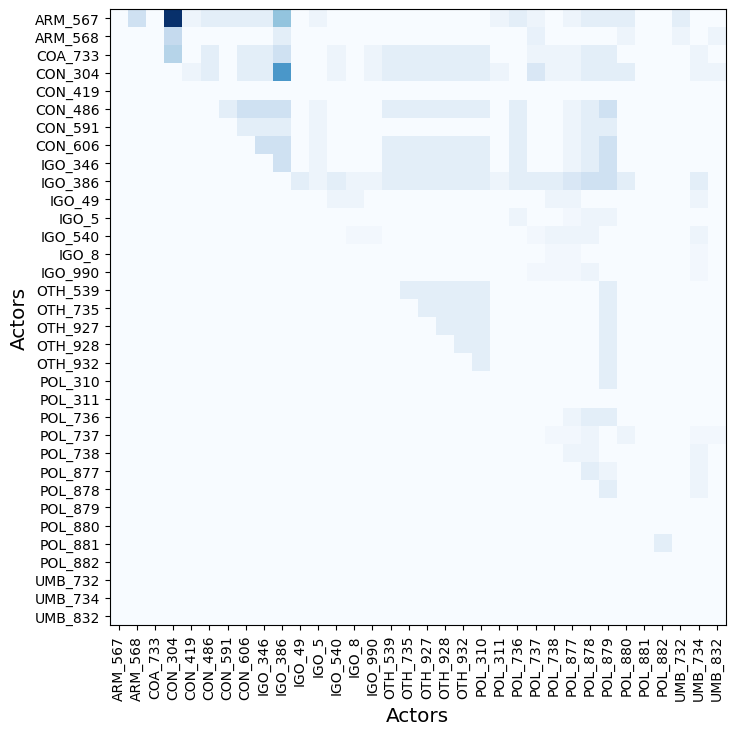

In [78]:
process_name = 'Yemen peace process'

yemen_pp_data_dict = get_peace_process_data(process_name,data_dict)
yemen_pp_matrix = yemen_pp_data_dict['matrix']

yemen_actor_upper = np.triu(get_cooccurrence_matrices(yemen_pp_matrix)[0],k=1)


f = plt.figure(figsize=(8,8))
plt.imshow(yemen_actor_upper,cmap=plt.cm.Blues)
plt.xticks(range(0,len(yemen_pp_data_dict['actor_ids'])),yemen_pp_data_dict['actor_ids'],rotation=90)
plt.yticks(range(0,len(yemen_pp_data_dict['actor_ids'])),yemen_pp_data_dict['actor_ids'])
plt.xlabel('Actors',fontsize='x-large')
plt.ylabel('Actors',fontsize='x-large')
plt.show()



## Backing space

Assume always directed from a PA-X actor in the peace process.


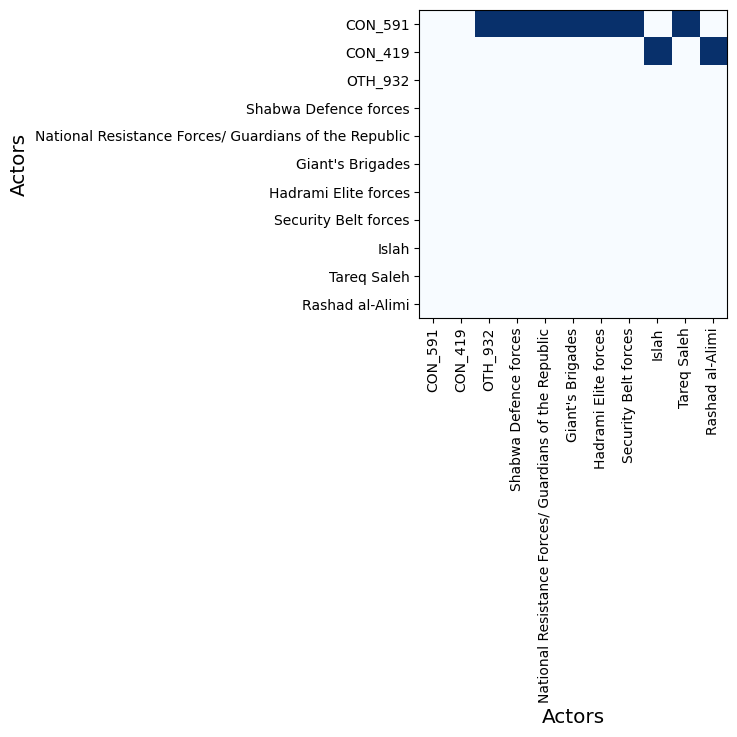

In [110]:
pax_actor_ids = ['CON_591','CON_419','OTH_932']

non_pax_actor_ids = ['Shabwa Defence forces','National Resistance Forces/ Guardians of the Republic',\
                     'Giant\'s Brigades','Hadrami Elite forces','Security Belt forces',\
                    'Islah','Tareq Saleh','Rashad al-Alimi']

actor_ids = []
actor_ids.extend(pax_actor_ids)
actor_ids.extend(non_pax_actor_ids)

backing_map = {}
backing_map['CON_591'] = []
backing_map['CON_591'].append('Shabwa Defence forces')
backing_map['CON_591'].append('National Resistance Forces/ Guardians of the Republic')
backing_map['CON_591'].append('Giant\'s Brigades')
backing_map['CON_591'].append('OTH_932')
backing_map['CON_591'].append('Hadrami Elite forces')
backing_map['CON_591'].append('Security Belt forces')
backing_map['CON_591'].append('Tareq Saleh')

backing_map['CON_419'] = []
backing_map['CON_419'].append('Islah')
backing_map['CON_419'].append('Rashad al-Alimi')

matrix = np.zeros((len(actor_ids),len(actor_ids)))
for backer,backed_list in backing_map.items():
    backer_index = actor_ids.index(backer)
    for backed in backed_list:
        backed_index = actor_ids.index(backed)
        matrix[backer_index,backed_index] = 1

f = plt.figure(figsize=(4,4))
plt.imshow(matrix,cmap=plt.cm.Blues)
plt.xticks(range(0,len(actor_ids)),actor_ids,rotation=90)
plt.yticks(range(0,len(actor_ids)),actor_ids)
plt.xlabel('Actors',fontsize='x-large')
plt.ylabel('Actors',fontsize='x-large')
plt.show()

yemen_data_dict = {}
yemen_data_dict['matrix'] = matrix
yemen_data_dict['actor_ids'] = actor_ids



### Overlap of sets of actors

Interactions in both spaces are only possible for actors in the intersection of the agreement and mediation event actor sets.


34


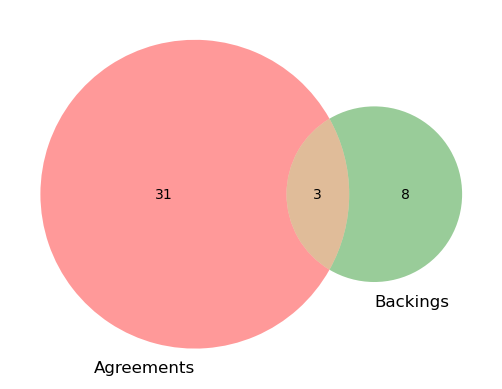

Actors in the intersection:

CON_591 United Arab Emirates
CON_419 Saudi Arabia
OTH_932 Southern Transitional Council



In [80]:
print(len(yemen_pp_data_dict['actor_ids']))

venn2([set(yemen_pp_data_dict['actor_ids']),set(yemen_data_dict['actor_ids'])],\
      ['Agreements','Backings'])       
plt.show()

print('Actors in the intersection:')
print()
intersection = set(yemen_pp_data_dict['actor_ids']).intersection(set(yemen_data_dict['actor_ids']))       
for actor_id in intersection:
    print(actor_id,get_actor_name(actor_id,data_dict))
print()


### Compute and visualise superimposition

- Combine actors from agreements and mediation events into a superset
- Build super matrices with superset actors in rows and columns:
    - One super matrix contains actor-actor interactions in the agreement space.
    - The other super matrix contains actor-actor interactions in the mediation event space.
    - Bitwise AND the matrices to provide a matrix containing actor-actor pairs with interactions in both the agreement and mediation event spaces.
- Plot network with one super matrix as the base space and superimpose the bitwise matrix with coloured edges to indicate an interaction between a pair of actors in the other space.
    


There are no superimposed edges.


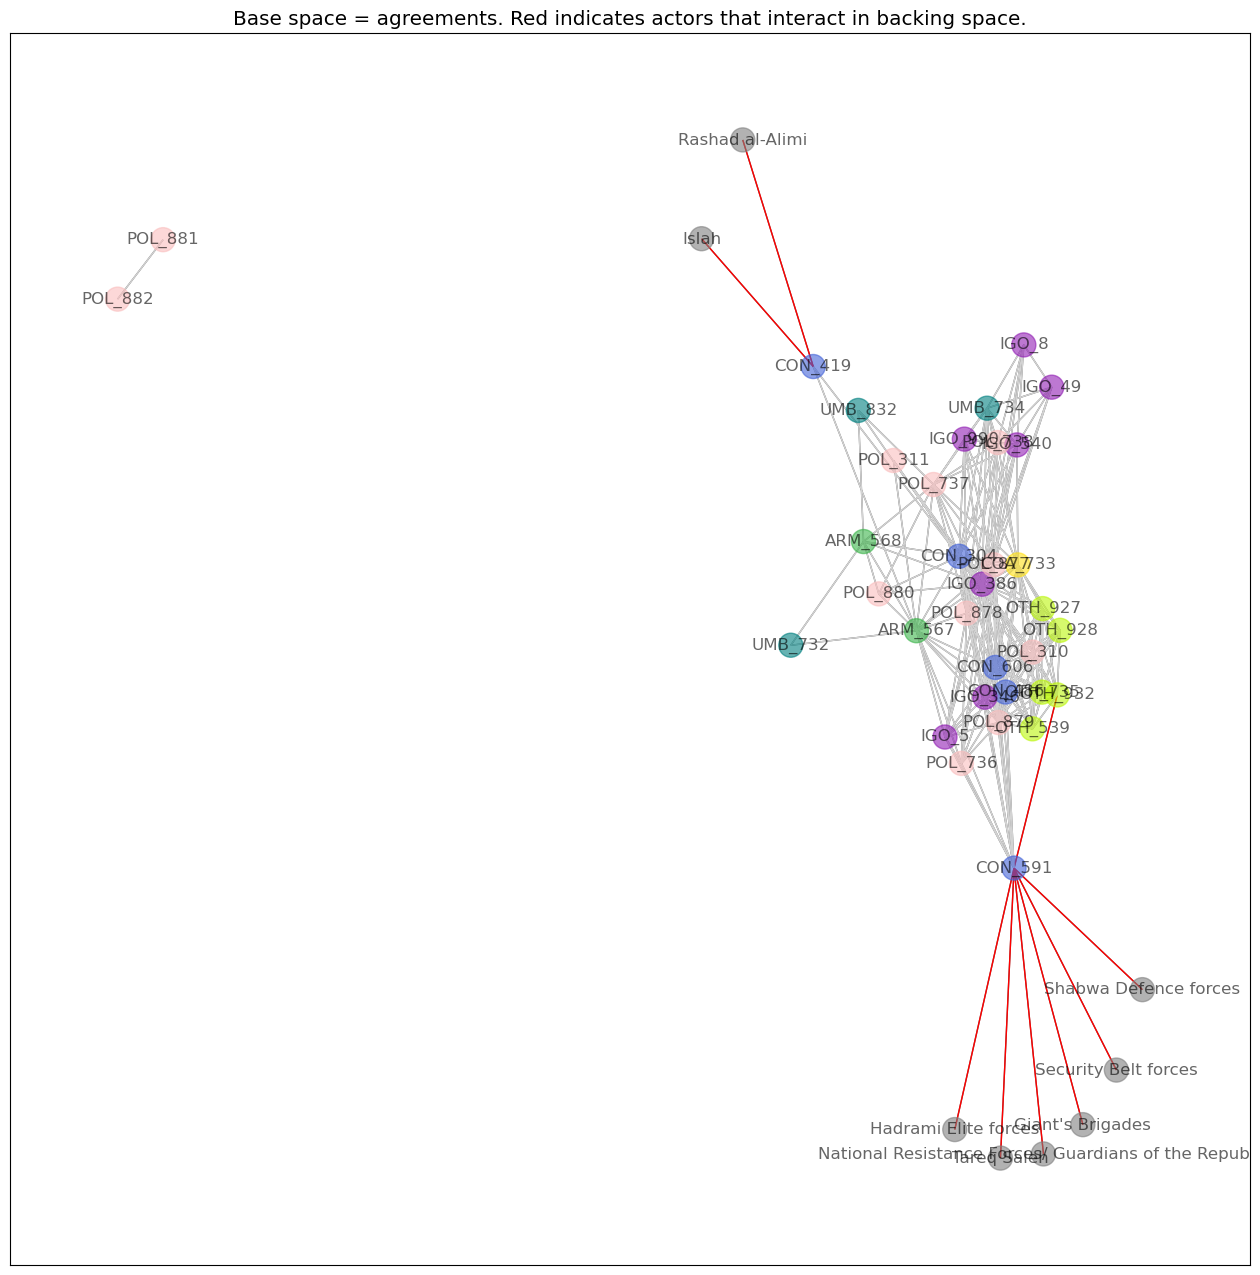

In [209]:

super_set = sorted(list(set(yemen_pp_data_dict['actor_ids']).union(set(yemen_data_dict['actor_ids']))))


matrix1 = np.zeros((len(super_set),len(super_set))).astype(np.int_)

indices_map1 = {i:super_set.index(name) for i,name in enumerate(yemen_pp_data_dict['actor_ids'])}
indices1 = list(np.where(yemen_actor_upper>0))
z = list(zip(indices1[0],indices1[1]))
z = [(indices_map1[t[0]],indices_map1[t[1]]) for t in z]
    
for t in z:
    matrix1[t[0],t[1]] = 1
    

matrix2 = np.zeros((len(super_set),len(super_set))).astype(np.int_)

indices_map2 = {i:super_set.index(name) for i,name in enumerate(yemen_data_dict['actor_ids'])}
indices2 = list(np.where(yemen_data_dict['matrix']>0))
z = list(zip(indices2[0],indices2[1]))
z2 = [(indices_map2[t[0]],indices_map2[t[1]]) for t in z]
z2.extend([(indices_map2[t[1]],indices_map2[t[0]]) for t in z])
    
for t in z2:
    matrix2[t[0],t[1]] = 1

c = np.bitwise_and(matrix1,matrix2)

if not np.any(c):
    print('There are no superimposed edges.')
    c = np.bitwise_or(matrix1,matrix2)

title = 'Base space = agreements. Red indicates actors that interact in backing space.'
visualise_superimposition(c,matrix2,super_set,data_dict,'red',title)

